In [1]:
import numpy as np
import pandas as pd
import keras
import matplotlib.pyplot as plt
from keras import layers

2024-08-03 14:23:07.963689: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-08-03 14:23:07.993926: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-08-03 14:23:08.446432: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
/usr/lib/python3/dist-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.17.3 and <1.25.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
#Coletando dados

df = pd.read_excel('/home/andre/Área de Trabalho/Reconstrução da Estatística Pesqueira BR/Rio de Janeiro/Crustaceos/RJ_Reconstrucao_Crustaceos_2024_06_25.xlsx')

df_Lagostas = pd.DataFrame(df[['Ano','Lagosta_art','Lagosta_ind','Lagosta_art_ind']])

#Somando art e ind em art_ind
for i in range(len(df_Lagostas['Ano'])):
  if pd.isnull(df_Lagostas.iloc[i,3])==True and pd.isnull(df_Lagostas.iloc[i,2])==False and pd.isnull(df_Lagostas.iloc[i,1])==False:
    df_Lagostas.iloc[i,3] = df_Lagostas.iloc[i,2] + df_Lagostas.iloc[i,1] 


dados = df_Lagostas[['Ano','Lagosta_art','Lagosta_art_ind']].dropna().reset_index(drop=True)

#Fazendo as proporções
for i in range(len(dados['Ano'])):
  dados.loc[i,'Prop_Lagosta_art'] = dados.loc[i,'Lagosta_art'] / dados.loc[i,'Lagosta_art_ind']


anos_com_dados = dados["Ano"].values
anos_para_prever = np.array([1962,1963,1964,1965,1966,1967,1968,1974,1976,1977])
todos_anos = np.concatenate((anos_para_prever, anos_com_dados))
todos_anos.sort()



prop = dados['Prop_Lagosta_art'].values

dados.head()

,Ano,Lagosta_art,Lagosta_art_ind,Prop_Lagosta_art
0,1978,18.0,20.0,0.900000
1,1980,1.0,6.0,0.166667
2,1981,0.5,35.5,0.014085
3,1982,2.0,4.0,0.500000
4,1983,5.0,6.0,0.833333


In [3]:
#Normalização dos dados

ano_mean = np.mean(anos_com_dados)
ano_std = np.std(anos_com_dados)
anos_para_prever_norm = (anos_para_prever - ano_mean)/ano_std
anos_com_dados_norm = (anos_com_dados - ano_mean)/ano_std

prop_mean = np.mean(prop)
prop_std = np.std(prop)
prop_norm = (prop - prop_mean)/prop_std

In [4]:
#Fit do modelo e salvando seus pesos
model = keras.Sequential([layers.Dense(96,activation='leaky_relu',input_shape=(1,)),
                             layers.Dense(32,activation='leaky_relu'),
                             layers.Dense(80,activation='leaky_relu'),
                             layers.Dense(80,activation='leaky_relu'),
                             layers.Dense(96,activation='leaky_relu'),
                             layers.Dense(112,activation='leaky_relu'),
                             layers.Dense(1,activation='linear')])

opt = keras.optimizers.Adam(learning_rate=0.001)
model.compile(optimizer=opt, loss='mse')


#history = model.fit(anos_com_dados_norm,prop_norm, epochs=115, verbose=1)
#model.save_weights('/home/andre/Área de Trabalho/Reconstrução da Estatística Pesqueira BR/Rio de Janeiro/Crustaceos/Lagosta/pesos prop Lagosta_art/.weights.h5', overwrite=True)

/home/andre/.local/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [5]:
model.load_weights('/home/andre/Área de Trabalho/Reconstrução da Estatística Pesqueira BR/Rio de Janeiro/Crustaceos/Lagosta/pesos prop Lagosta_art/.weights.h5')

/home/andre/.local/lib/python3.10/site-packages/keras/src/saving/saving_lib.py:415: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Previsões dos dados ausentes: [[0.9249687 ]
 [0.9092797 ]
 [0.89398575]
 [0.87861973]
 [0.8622499 ]
 [0.84485376]
 [0.82654643]
 [0.7074815 ]
 [0.65182215]
 [0.6110807 ]]


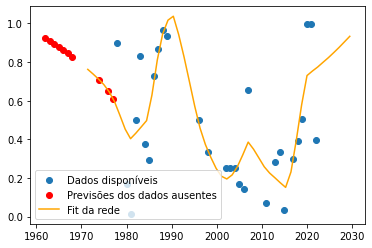

In [6]:
#Previsões
prev_disponiveis = model.predict(anos_com_dados_norm)*prop_std + prop_mean
prev_ausentes = model.predict(anos_para_prever_norm)*prop_std + prop_mean

#Colocando valores negativos para 0
for i in range(len(prev_ausentes)):
    if prev_ausentes[i]<0:
        prev_ausentes[i]=0
    if prev_ausentes[i]>=1:
        prev_ausentes[i]=1

#Plot dos dados e previsões
f1=plt.figure(1).add_subplot()
f1.scatter(anos_com_dados,prop,label='Dados disponíveis')
f1.scatter(anos_para_prever,prev_ausentes, color='red', label='Previsões dos dados ausentes')

#Plot do fit da rede
p = np.linspace(-2,2,50)
y = model.predict(p)*prop_std + prop_mean
f1.plot(p*ano_std + ano_mean,y,color='orange',label='Fit da rede')

#Print das previsões
print('Previsões dos dados ausentes:', prev_ausentes)


plt.legend()
plt.show()

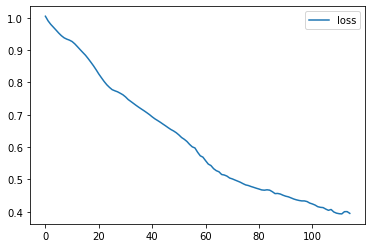

In [33]:
loss = history.history['loss']
plt.plot(loss,label='loss')
plt.legend()
plt.show()

In [8]:
#Lista de anos sem buracos normalizada e sua predição      (para poder me referir por indices)

anos = np.arange(1950,np.max(anos_para_prever)+1)
anos_norm = (anos-ano_mean)/ano_std
prev_continua = model.predict(anos_norm)*prop_std + prop_mean

for i in range(len(prev_continua)):
    if prev_continua[i]<0:
        prev_continua[i]=0
    if prev_continua[i]>=1:
        prev_continua[i]=1

#Trazendo valores previstos para Lagosta_art_ind
df_prev_Lag_art_ind = pd.read_excel('/home/andre/Área de Trabalho/Reconstrução da Estatística Pesqueira BR/Rio de Janeiro/Crustaceos/Desagregações 1950-1974/Desagregações 1950-1974.xlsx')
df_prev_Lag_art_ind = df_prev_Lag_art_ind[['Ano','Lagosta_art_ind']]

df_preenchido = df[['Ano','Lagosta_art']]
for i in range(len(prev_continua)):
    if i+1950 in anos_para_prever:
      df_preenchido.loc[i,'Lagosta_art']=df_prev_Lag_art_ind.loc[i,'Lagosta_art_ind']*prev_continua[i]

df_preenchido = df_preenchido.loc[:,:]
with pd.option_context('display.max_rows', None,):
    print(df_preenchido)


#Planilha com os dados preenchidos
df_preenchido.to_excel('/home/andre/Área de Trabalho/Reconstrução da Estatística Pesqueira BR/Rio de Janeiro/Crustaceos/Lagosta/Previsão Lagosta_art_1962-1977.xlsx')


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
     Ano  Lagosta_art
0   1950          NaN
1   1951          NaN
2   1952          NaN
3   1953          NaN
4   1954          NaN
5   1955          NaN
6   1956          NaN
7   1957          NaN
8   1958          NaN
9   1959          NaN
10  1960          NaN
11  1961          NaN
12  1962     7.399750
13  1963    30.915510
14  1964    11.621815
15  1965    43.954079
16  1966    13.795999
17  1967    59.984615
18  1968   364.506989
19  1969          NaN
20  1970          NaN
21  1971          NaN
22  1972          NaN
23  1973          NaN
24  1974    46.271778
25  1975          NaN
26  1976    16.947376
27  1977   309.206848
28  1978    18.000000
29  1979          NaN
30  1980     1.000000
31  1981     0.500000
32  1982     2.000000
33  1983     5.000000
34  1984     3.000000
35  1985     5.000000
36  1986     8.000000
37  1987    13.000000
38  1988    14.000000
39  1989    15.000000
40  1990          NaN
41  1991          NaN
42  1992        